In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# 파일경로 설정
import os
import shutil
import json

# Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# GPU 환경 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt


In [ ]:
import numpy as np 
import pandas as pd 
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from PIL import Image 
import seaborn as sns
import os 
from os import listdir, makedirs
from os.path import join, exists, expanduser
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from numpy import newaxis
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense,Activation,Dropout,Flatten,BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, applications, Sequential, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import SVG
from keras.applications.vgg19 import VGG19
from skimage.feature import local_binary_pattern
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
data_path = '/content/drive/MyDrive/hand_final'


train_path = data_path + '/train'
test_path = data_path + '/test'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [ ]:
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
train_folders[:5]

['/content/drive/MyDrive/hand_final/train/0',
 '/content/drive/MyDrive/hand_final/train/1',
 '/content/drive/MyDrive/hand_final/train/2',
 '/content/drive/MyDrive/hand_final/train/3',
 '/content/drive/MyDrive/hand_final/train/4']

In [ ]:
train_folder = train_folders[0]

image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
json_path   = glob(train_folder + '/*.json')[0]

(1080, 1920, 3)


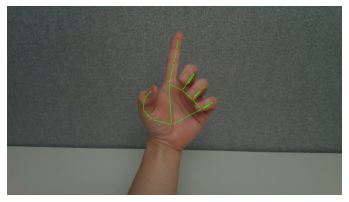

In [ ]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [ ]:
js = json.load(open(json_path))

print("json keys             : ", js.keys())

print("json action info       : ",js.get('action'))

print("json id info       : ",js.get('id'))

print("json annotations info       : ",js.get('annotations'))

print("json annotations keys : ",js.get('annotations')[0].keys())

json keys             :  dict_keys(['action', 'actor', 'id', 'annotations'])
json action info       :  [0, '숫자 1']
json id info       :  0
json annotations info       :  [{'image_id': 0, 'data': [[943.4659194946289, 678.9908051490784, -0.07258573779836297], [831.5485382080078, 649.4491910934448, -154.91628170013428], [780.9441375732422, 594.6215343475342, -249.13023948669434], [786.9584655761719, 526.9233298301697, -319.0608215332031], [829.5905113220215, 482.93885707855225, -370.178861618042], [928.8368225097656, 445.8325123786926, -188.57235431671143], [956.165885925293, 325.0832176208496, -259.99417304992676], [972.0347213745117, 247.1524554491043, -332.45018005371094], [978.2339859008789, 186.77878975868225, -390.15440940856934], [1004.2246627807617, 481.9052195549011, -174.55859184265137], [1072.829360961914, 383.75391125679016, -316.6427993774414], [1066.5202331542969, 404.170618057251, -439.74520683288574], [1037.7899551391602, 442.18912839889526, -514.8169326782227], [1062.5819

In [ ]:
answers = []
for train_folder in train_folders :
    json_path = glob(train_folder + '/*.json')[0]
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    cat_name = js.get('action')[1] 
    answers.append([train_folder.replace(data_path,''),cat, cat_name])

answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
answers

,train_path,answer,answer_name
0,/train/0,0,숫자 1
1,/train/1,0,숫자 1
2,/train/2,10,숫자 1
3,/train/3,10,숫자 1
4,/train/4,10,숫자 1
...,...,...,...
644,/train/644,194,빅토리
645,/train/645,195,부정(엄지손 아래로)
646,/train/646,195,부정(엄지손 아래로)
647,/train/647,195,부정(엄지손 아래로)


In [ ]:
classes = pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy()

In [ ]:
np.random.shuffle(train_folders) # 일반화 가능성 높이기

In [ ]:

images  = []
targets = []
for train_folder in tqdm(train_folders) :
    image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
    query_path  = train_folder.replace(data_path,'')
    target = classes[int(train_folder.split('/')[-1])] 
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(256,256,3))
        img = image.img_to_array(img)
        img = img/255
        images.append(img)
        targets.append(target)

100%|██████████| 649/649 [1:52:12<00:00, 10.37s/it]


In [ ]:
X = np.array(images)
print('Train X Shape : ', X.shape)

y = np.array(targets)
print('Train y Shape : ', y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=2021, 
                                                      test_size=0.2, 
                                                      stratify = y)

print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)
print('y_train shape : ', y_train.shape)
print('y_valid shape : ', y_valid.shape)

Train X Shape :  (5888, 256, 256, 3)
Train y Shape :  (5888, 157)
X_train shape :  (4710, 256, 256, 3)
X_valid shape :  (1178, 256, 256, 3)
y_train shape :  (4710, 157)
y_valid shape :  (1178, 157)


42 total epochs and 368 steps per epoch
Learning rate schedule: 2e-06 to 0.01 to 7.34e-06


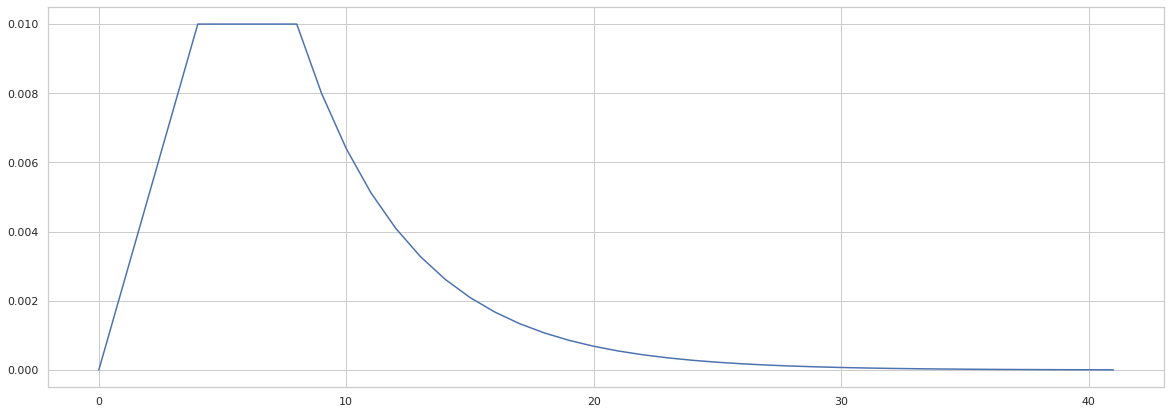

In [ ]:
image_shape=(256,256,3)
BATCH_SIZE = 16 
EPOCHS =42
LEARNING_RATE = 1e-2 
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
N_CLASSES = 157
ES_PATIENCE = 5
LR_START = 0.000002
LR_MIN = 0.000001
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {5888//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [ ]:
base_model = tf.keras.applications.EfficientNetB5(input_shape=(256,256,3), include_top=False, weights='imagenet')
base_model.trainable=True

115277824/115263384 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(N_CLASSES , activation='softmax')])
checkpoint_path = data_path + 'model/efficientnetb5.h5'
callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lrfn(EPOCHS)), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid) , epochs=EPOCHS, callbacks=[callbacks])

Epoch 1/42
148/148 [==============================] - 2033s 14s/step - loss: 5.0078 - accuracy: 0.0113 - val_loss: 5.0921 - val_accuracy: 0.0076

Epoch 00001: val_loss improved from inf to 5.09206, saving model to /content/drive/MyDrive/hand_finalmodel/efficientnetb5.h5
Epoch 2/42
148/148 [==============================] - 1950s 13s/step - loss: 4.7619 - accuracy: 0.0828 - val_loss: 5.0647 - val_accuracy: 0.0102

Epoch 00002: val_loss improved from 5.09206 to 5.06466, saving model to /content/drive/MyDrive/hand_finalmodel/efficientnetb5.h5
Epoch 3/42
148/148 [==============================] - 1942s 13s/step - loss: 4.4852 - accuracy: 0.2482 - val_loss: 5.0867 - val_accuracy: 0.0059

Epoch 00003: val_loss did not improve from 5.06466
Epoch 4/42
148/148 [==============================] - 1953s 13s/step - loss: 4.1837 - accuracy: 0.4170 - val_loss: 5.0629 - val_accuracy: 0.0051

Epoch 00004: val_loss improved from 5.06466 to 5.06290, saving model to /content/drive/MyDrive/hand_finalmodel/

In [ ]:
model = tf.keras.models.load_model(data_path + 'model/efficientnetb5.h5')

In [ ]:
test_images  = []
for test_folder in tqdm(test_folders, total = len(test_folders)) :
    image_paths = sorted(glob(test_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
    query_path  = test_folder.replace(data_path,'')
    test_image = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(256,256,3))
        img = image.img_to_array(img)
        img = img/255
        test_image.append(img)
    test_images.append(test_image)

test_images = np.array(test_images)
print(test_images.shape)

100%|██████████| 217/217 [36:45<00:00, 10.16s/it]

(217,)


In [ ]:
predictions = []
for test_image in tqdm(test_images, total = len(test_images)) : 
    prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
    predictions.append(prediction)

sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv(data_path + '/EFFICIENTNETB5.csv', index=False)

100%|██████████| 217/217 [03:56<00:00,  1.09s/it]


,Image_Path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8,Label_9,Label_10,Label_11,Label_12,Label_13,Label_14,Label_15,Label_16,Label_17,Label_18,Label_19,Label_22,Label_23,Label_25,Label_26,Label_27,Label_28,Label_29,Label_31,Label_32,Label_34,Label_35,Label_36,Label_37,Label_39,Label_40,Label_41,Label_42,Label_43,Label_44,...,Label_142,Label_143,Label_144,Label_145,Label_146,Label_147,Label_148,Label_149,Label_150,Label_151,Label_153,Label_154,Label_155,Label_156,Label_157,Label_158,Label_159,Label_160,Label_161,Label_162,Label_163,Label_165,Label_167,Label_168,Label_169,Label_171,Label_172,Label_173,Label_174,Label_175,Label_177,Label_186,Label_188,Label_189,Label_190,Label_191,Label_192,Label_193,Label_194,Label_195
0,./test\649,0.000000e+00,4.784538e-25,0.000000e+00,0.000000e+00,2.019964e-23,4.578775e-11,5.755800e-25,0.000000e+00,1.345000e-32,1.250213e-35,0.911225,3.487576e-22,4.286254e-30,7.695662e-33,1.712275e-37,1.591880e-19,9.509503e-17,3.736342e-24,3.498235e-36,7.894968e-35,3.486111e-29,0.000000e+00,0.000000e+00,1.279211e-26,0.000000e+00,7.124578e-30,9.083503e-32,1.706490e-33,6.630549e-30,9.761965e-17,2.601722e-12,3.896153e-17,7.712317e-35,0.000000e+00,4.183358e-37,1.022665e-31,1.070237e-18,1.187077e-20,9.041254e-32,...,2.156999e-25,2.072800e-35,0.000000e+00,1.289637e-30,0.000000e+00,0.000000e+00,0.087803,1.874671e-16,6.880734e-34,5.388674e-25,0.000000e+00,7.207526e-13,1.487021e-09,1.376961e-23,5.497494e-28,8.343281e-35,0.000000e+00,2.345598e-27,2.015119e-19,3.143986e-09,5.367868e-06,2.584114e-31,4.699387e-31,9.668132e-04,2.264071e-22,8.271543e-39,5.120931e-25,6.100048e-26,3.106494e-28,3.744643e-11,0.000000e+00,0.000000e+00,0.000000e+00,2.719269e-32,0.000000e+00,1.921487e-27,0.000000e+00,2.094146e-19,2.142569e-18,0.000000e+00
1,./test\650,3.543418e-37,3.849553e-19,3.241418e-37,8.274084e-33,1.021342e-19,1.545239e-11,1.040466e-23,0.000000e+00,7.496346e-26,4.014335e-33,0.698027,8.559098e-20,8.196028e-25,8.416351e-29,2.295013e-32,1.233710e-15,4.386436e-17,3.217141e-22,1.876334e-30,3.424085e-31,1.380014e-25,8.716571e-32,1.128685e-36,2.070406e-21,0.000000e+00,1.190511e-23,5.176886e-27,7.550968e-31,1.140445e-25,3.302814e-13,1.692459e-05,5.491732e-19,5.960237e-29,1.931998e-37,4.296858e-30,7.683812e-26,1.748633e-16,5.130625e-12,1.638589e-27,...,5.785601e-22,1.223653e-32,7.199636e-37,1.302338e-30,0.000000e+00,3.258453e-37,0.299578,6.415421e-16,2.088092e-31,1.153160e-21,0.000000e+00,7.023339e-09,1.583291e-09,2.322768e-20,7.826082e-22,3.810130e-32,1.010140e-33,4.052866e-20,2.180535e-18,9.348755e-09,3.945757e-06,2.641170e-30,1.132709e-29,2.305760e-03,5.569832e-21,1.458498e-35,2.669394e-22,8.763117e-24,2.305937e-26,2.770102e-11,2.096998e-36,0.000000e+00,3.403719e-39,7.128129e-28,0.000000e+00,2.637603e-26,0.000000e+00,1.794057e-18,2.533651e-17,4.130457e-38
2,./test\651,2.836165e-28,1.068846e-20,1.129169e-34,2.681823e-29,1.871120e-21,1.388077e-14,8.234664e-11,2.622516e-18,1.474913e-25,1.289189e-25,0.974615,5.903372e-12,1.443485e-14,2.363887e-23,5.755822e-32,3.292178e-16,3.270674e-18,6.483106e-22,5.346186e-29,5.238821e-20,1.511643e-21,4.416969e-20,1.843080e-20,4.089742e-22,4.265003e-19,9.887098e-26,1.188763e-24,1.662576e-25,3.879721e-18,1.994345e-13,3.480115e-06,8.456518e-13,5.828311e-23,4.719051e-21,3.476541e-23,1.745250e-08,1.991062e-16,1.571382e-14,6.880417e-21,...,1.473660e-24,8.661740e-20,6.922157e-38,4.197398e-32,6.202753e-33,7.257660e-27,0.003783,2.431273e-17,5.900496e-17,1.121938e-21,8.370531e-34,7.304780e-04,3.163123e-12,1.467842e-19,2.670398e-23,5.502902e-20,1.676723e-35,5.083862e-16,2.546924e-12,2.447992e-11,7.886771e-10,2.183653e-27,1.675716e-31,1.907505e-05,5.481937e-21,7.841605e-36,4.966898e-22,3.805537e-25,7.622511e-27,1.813465e-11,1.357998e-33,1.703055e-34,0.000000e+00,9.636948e-30,7.758487e-31,6.660150e-25,7.879353e-36,1.449892e-13,6.838660e-20,4.656001e-31
3,./test\652,6.609912e-23,1.210152e-18,1.586245e-17,7.829941e-21,3.147538e-08,1.286373e-11,1.351845e-07,2.820897e-18,3.459980e-23,5.786